In [2]:
!pip install pyshp


  Running setup.py bdist_wheel for pyshp: started
  Running setup.py bdist_wheel for pyshp: finished with status 'done'
  Stored in directory: C:\Users\me.bazzi\AppData\Local\pip\Cache\wheels\a6\0c\de\321b5192ad416b328975a2f0385f72c64db4656501eba7cc1a
Successfully built pyshp


In [1]:
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(10,6))

In [3]:
%matplotlib inline

In [4]:
shp_path = "d:/me.bazzi/Mes documents/Hackathon/electhon/données TAFRA/dossier électoral 2021/data/4.shp"
sf = shp.Reader(shp_path)

In [5]:
len(sf.shapes())

1538

In [6]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    
    fields = [x[0] for x in sf.fields][1:]
    records = [y[:] for y in sf.records()]
    
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

In [7]:
df = read_shapefile(sf)
df.shape

(1538, 2)

In [8]:
df.head()

idUnit                                             coords
0   670.0  [(-675919.3327011392, 4008227.5459214523), (-6...
1   671.0  [(-732465.3026649095, 3967970.458962828), (-73...
2   680.0  [(-705296.7460595891, 4017111.272471331), (-70...
3   686.0  [(-725474.1874846369, 4030928.46299731), (-725...
4   667.0  [(-642815.8329700455, 4005020.414840959), (-64...

In [9]:
df['idUnit'] = df.idUnit.astype(int)

In [10]:
def plot_map(sf, x_lim = None, y_lim = None, figsize = (50,40)):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize = figsize)
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')
        
        if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            plt.text(x0, y0, id, fontsize=10)
        id = id+1
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

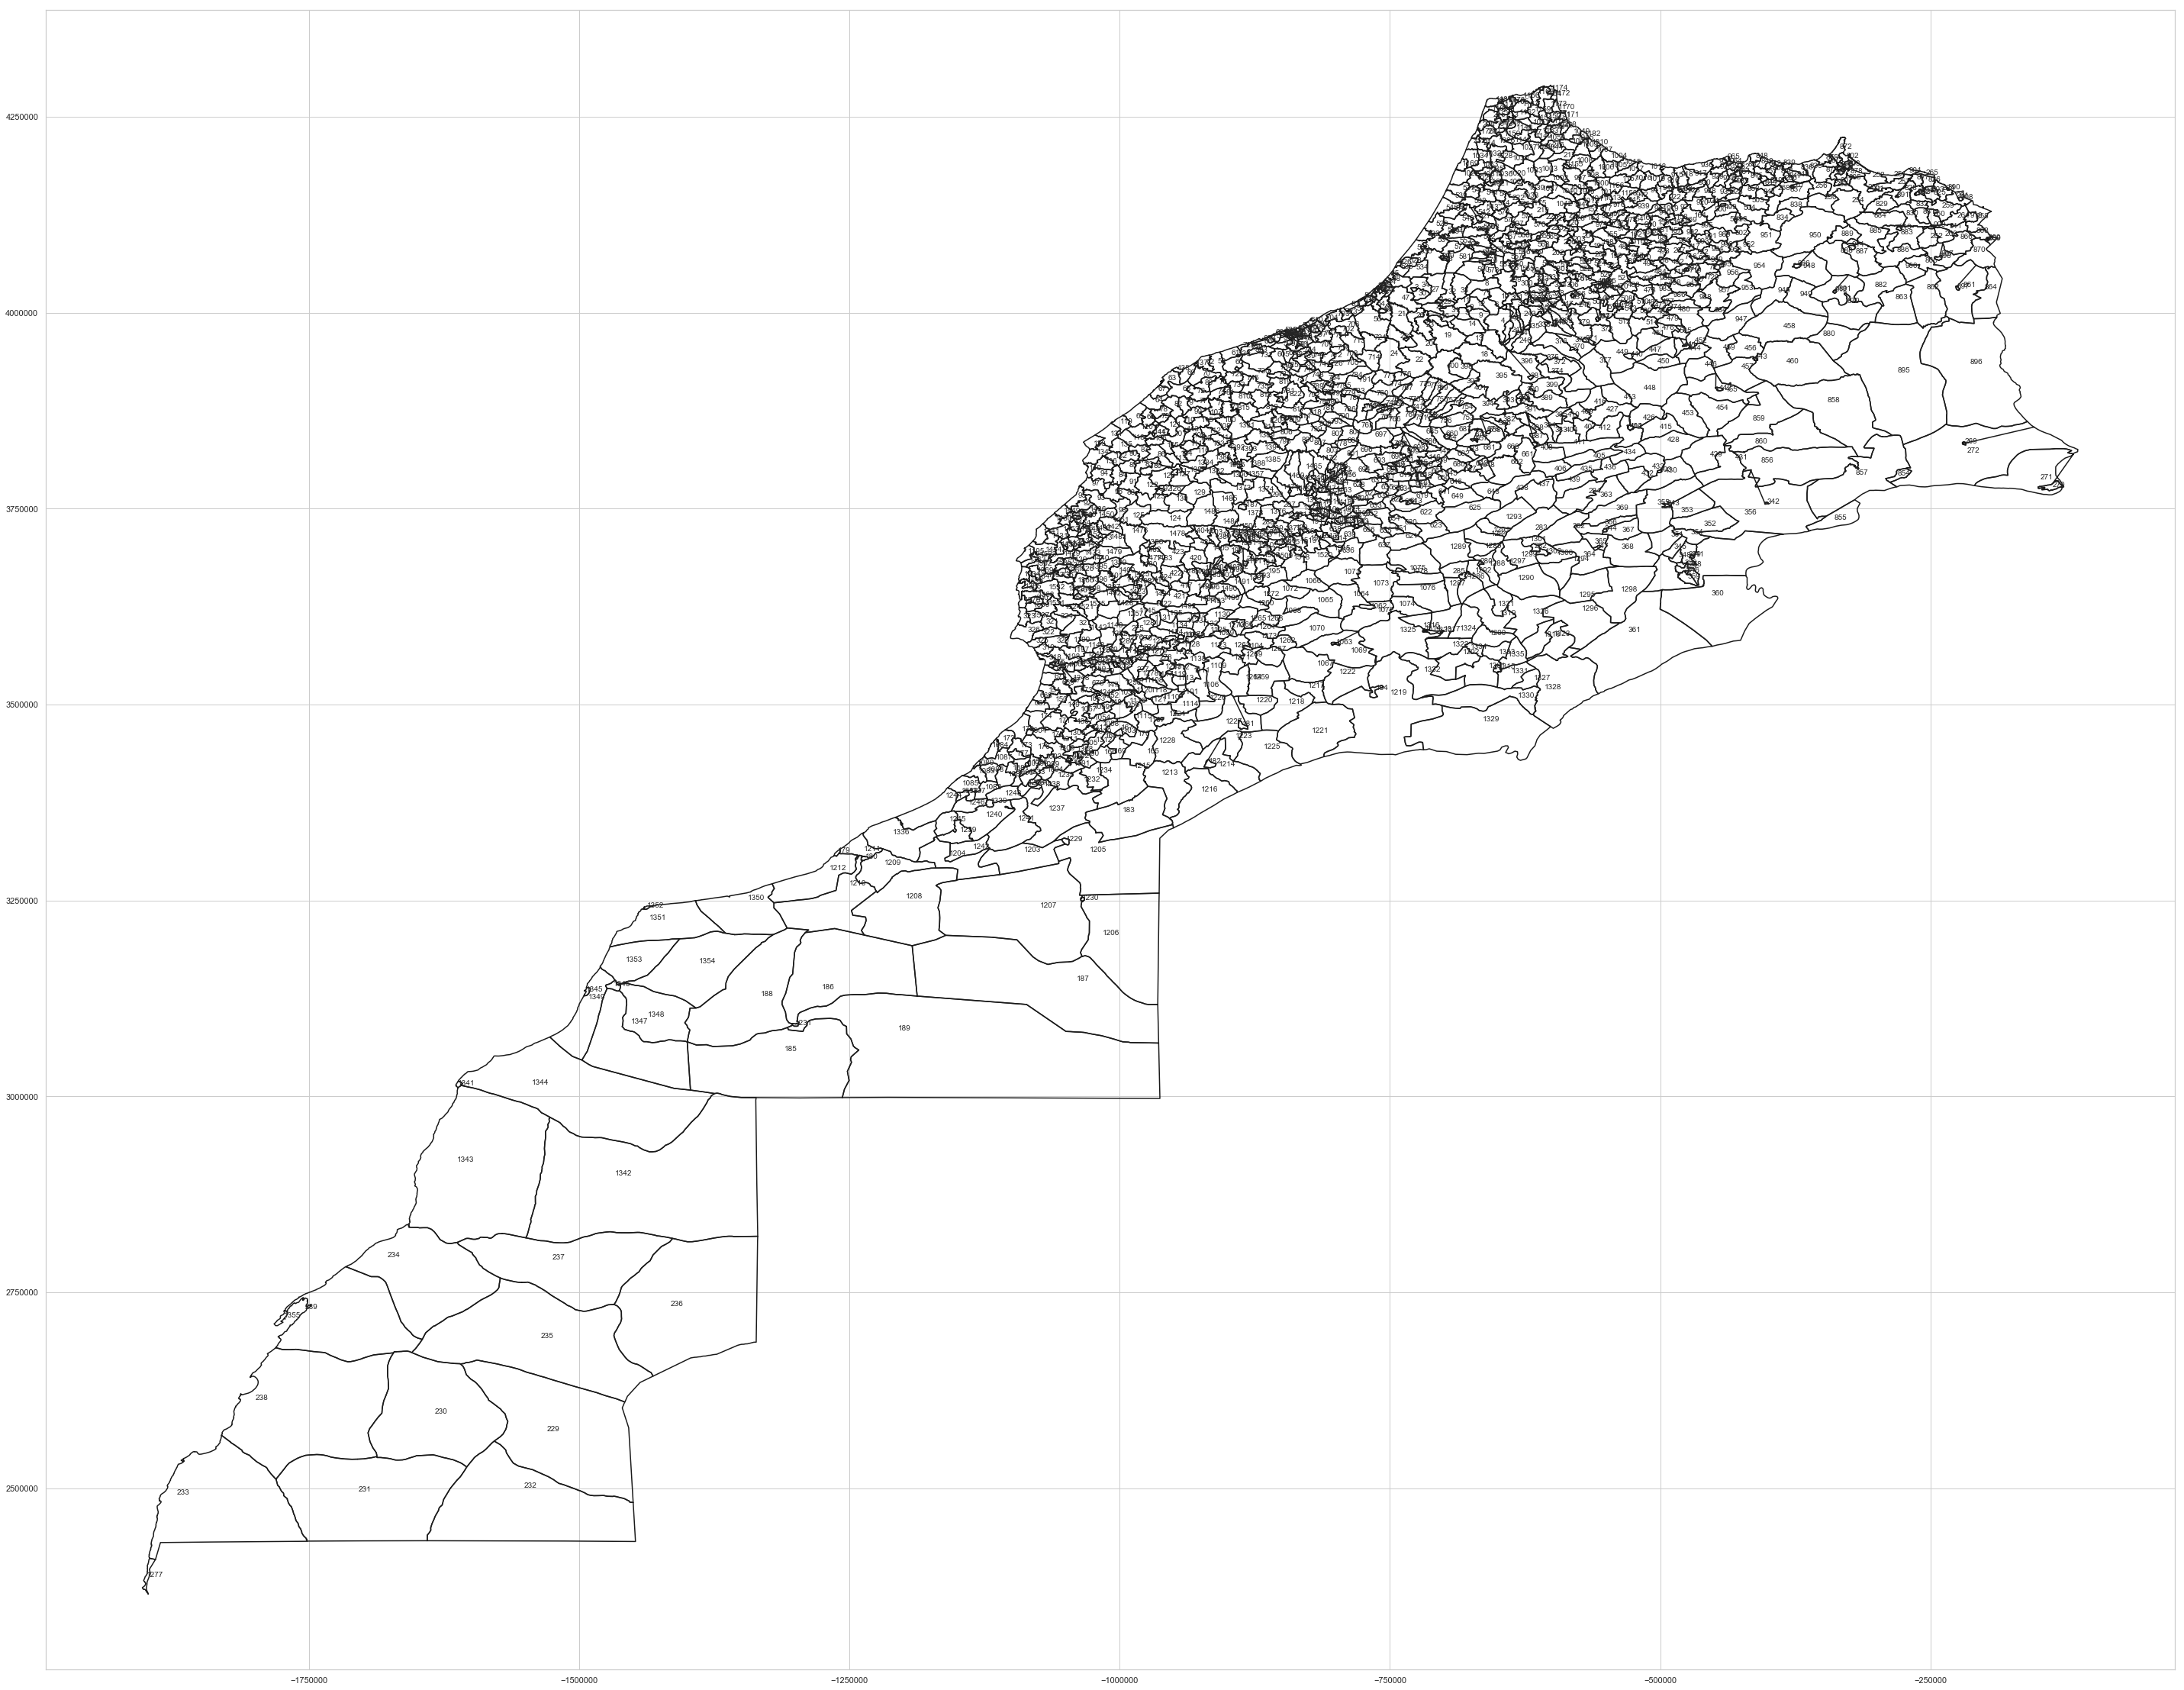

In [11]:
plot_map(sf)

In [12]:
def calc_color(data, color=None):
        if color   == 1: color_sq = ['#dadaebFF','#bcbddcF0','#9e9ac8F0','#807dbaF0','#6a51a3F0','#54278fF0']; colors = 'Purples';
        elif color == 2: color_sq = ['#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#253494']; colors = 'YlGnBu';
        elif color == 3: color_sq = ['#f7f7f7','#d9d9d9','#bdbdbd','#969696','#636363','#252525']; colors = 'Greys';
        elif color == 9: color_sq = ['#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000']
        else:            color_sq = ['#ffffd4','#fee391','#fec44f','#fe9929','#d95f0e','#993404']; colors = 'YlOrBr';
        new_data, bins = pd.qcut(data, 6, retbins=True, labels=list(range(6)))
        color_ton = []
        for val in new_data:
            color_ton.append(color_sq[val]) 
        if color != 9:
            colors = sns.color_palette(colors, n_colors=6)
            sns.palplot(colors, 0.6);
            for i in range(6):
                print ("\n"+str(i+1)+': '+str(int(bins[i]))+" => "+str(int(bins[i+1])-1), end =" ")
            print("\n\n   1   2   3   4   5   6")    
        return color_ton, bins;

In [13]:
def plot_comunas_data(sf, title, comunas, data=None, 
                      color=None, print_id=False):
    '''
    Plot map with selected comunes, using specific color
    '''
    
    color_ton, bins = calc_color(data, color)
    df = read_shapefile(sf)
    comuna_id = []
    for i in comunas:
        comuna_id.append(df[df.idUnit == 
                            i].index.get_values()[0])
    plot_map_fill_multiples_ids_tone(sf, title, comuna_id, 
                                     print_id, 
                                     color_ton, 
                                     bins, 
                                     x_lim = None, 
                                     y_lim = None, 
                                     figsize = (100,100));

In [14]:
def plot_map_fill_multiples_ids_tone(sf, title, comuna,  
                                     print_id, color_ton, 
                                     bins, 
                                     x_lim = None, 
                                     y_lim = None, 
                                     figsize = (11,9)):
    '''
    Plot map with lim coordinates
    '''
        
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=16)

    for shape in sf.shapeRecords():
        for i in range(len(shape.shape.parts)):
            i_start = shape.shape.parts[i]
            if i==len(shape.shape.parts)-1:
                i_end = len(shape.shape.points)
            else:
                i_end = shape.shape.parts[i+1]
            x = [i[0] for i in shape.shape.points[i_start:i_end]]
            y = [i[1] for i in shape.shape.points[i_start:i_end]]
            plt.plot(x, y, 'k')
            
    for id in comuna:
        shape_ex = sf.shape(id)
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]
        ax.fill(x_lon,y_lat, color_ton[comuna.index(id)])
        if print_id != False:
            x0 = np.mean(x_lon)
            y0 = np.mean(y_lat)
            plt.text(x0, y0, id, fontsize=10)
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)
        
    fig.savefig(title);

### Read the CSV

In [50]:
df_data = pd.read_excel('d:/me.bazzi/Mes documents/Global poverty rate.xlsx')

In [51]:
df_data.head()

idCommune       IPM       IPP       TPM       TPG   compEdu  compHabitat  \
0       2023  0.238146  0.454706  0.523736       NaN       NaN          NaN   
1       2023  0.084689  0.430630  0.196664  0.216271  0.532424     0.110736   
2       2034  0.130420  0.438075  0.297711       NaN       NaN          NaN   
3       2034  0.017678  0.383782  0.046062  0.054577  0.580867     0.083964   
4       2030  0.030166  0.396476  0.076086       NaN       NaN          NaN   

   compInfrastrut  compSante  distribPMonetaire  distribPMonetaireMultidim  \
0             NaN        NaN                NaN                        NaN   
1        0.294455   0.062385           0.019486                   0.027351   
2             NaN        NaN                NaN                        NaN   
3        0.195458   0.139711           0.008548                   0.002630   
4             NaN        NaN                NaN                        NaN   

   distribPMultidim  IPM_c  
0               NaN  11451  
1          0.169434  11451  
2               NaN  15692  
3          0.043399  15692  
4               NaN  57101

In [52]:
from sklearn.preprocessing import StandardScaler
X = df_data.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[ 1.09584574,  0.94117655,  1.0988411 , ..., -0.45018839,
        -0.66040774, -0.2244435 ],
       [-0.39797965,  0.36300955, -0.41337862, ...,  0.37352469,
         0.96095948, -0.2244435 ],
       [ 0.04718275,  0.54181442,  0.05381006, ..., -0.45018839,
        -0.66040774, -0.13427882],
       ...,
       [-0.21850961, -0.32122586, -0.1369821 , ...,  0.40745429,
         1.52108973, -0.32604619],
       [ 0.61028279,  0.27633424,  0.7157622 , ..., -0.45018839,
        -0.66040774, -0.27125855],
       [-0.14526477, -0.19076631, -0.06743064, ...,  0.31745921,
         1.69363404, -0.27125855]])

In [53]:
from sklearn.cluster import KMeans 
clusterNum = 5
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[0 0 0 ... 0 0 0]


In [54]:
df_data["Clus_km"] = labels

df_data.head(5)

idCommune       IPM       IPP       TPM       TPG   compEdu  compHabitat  \
0       2023  0.238146  0.454706  0.523736       NaN       NaN          NaN   
1       2023  0.084689  0.430630  0.196664  0.216271  0.532424     0.110736   
2       2034  0.130420  0.438075  0.297711       NaN       NaN          NaN   
3       2034  0.017678  0.383782  0.046062  0.054577  0.580867     0.083964   
4       2030  0.030166  0.396476  0.076086       NaN       NaN          NaN   

   compInfrastrut  compSante  distribPMonetaire  distribPMonetaireMultidim  \
0             NaN        NaN                NaN                        NaN   
1        0.294455   0.062385           0.019486                   0.027351   
2             NaN        NaN                NaN                        NaN   
3        0.195458   0.139711           0.008548                   0.002630   
4             NaN        NaN                NaN                        NaN   

   distribPMultidim  IPM_c  Clus_km  
0               NaN  11451        0  
1          0.169434  11451        0  
2               NaN  15692        0  
3          0.043399  15692        0  
4               NaN  57101        4

In [55]:
df_data.idCommune.dtypes

dtype('int64')

In [56]:
df_data.groupby('Clus_km').mean()

idCommune       IPM       IPP       TPM       TPG   compEdu  \
Clus_km                                                                  
0        1416.888889  0.139227  0.421583  0.316196  0.250536  0.548880   
1        1215.092593  0.026281  0.378692  0.066252  0.043607  0.593801   
2        1307.900000  0.019157  0.373331  0.049441  0.022011  0.595408   
3        1092.964286  0.018179  0.373059  0.047157  0.025140  0.583309   
4        1419.271795  0.089203  0.405839  0.206618  0.148370  0.603617   

         compHabitat  compInfrastrut  compSante  distribPMonetaire  \
Clus_km                                                              
0           0.142319        0.190642   0.116555           0.060604   
1           0.047506        0.097904   0.260790           0.019877   
2           0.032982        0.079139   0.292471           0.007484   
3           0.031830        0.100446   0.284415           0.010002   
4           0.092714        0.146660   0.157008           0.048015   

         distribPMonetaireMultidim  distribPMultidim          IPM_c  
Clus_km                                                              
0                         0.033922          0.156010    9288.888889  
1                         0.002212          0.021518  103011.259259  
2                         0.000563          0.013964  434694.300000  
3                         0.000867          0.014270  207761.392857  
4                         0.018104          0.082251   33338.317949

In [ ]:
df_data.groupby('Clus_km').mean()

In [25]:
df_data.idCommune.dtypes

dtype('int64')


1: 0 => 5112 
2: 5113 => 7512 
3: 7513 => 10237 
4: 10238 => 14344 
5: 14345 => 23365 
6: 23366 => 520427 

   1   2   3   4   5   6


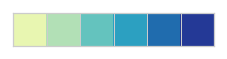

<Figure size 7200x7200 with 0 Axes>

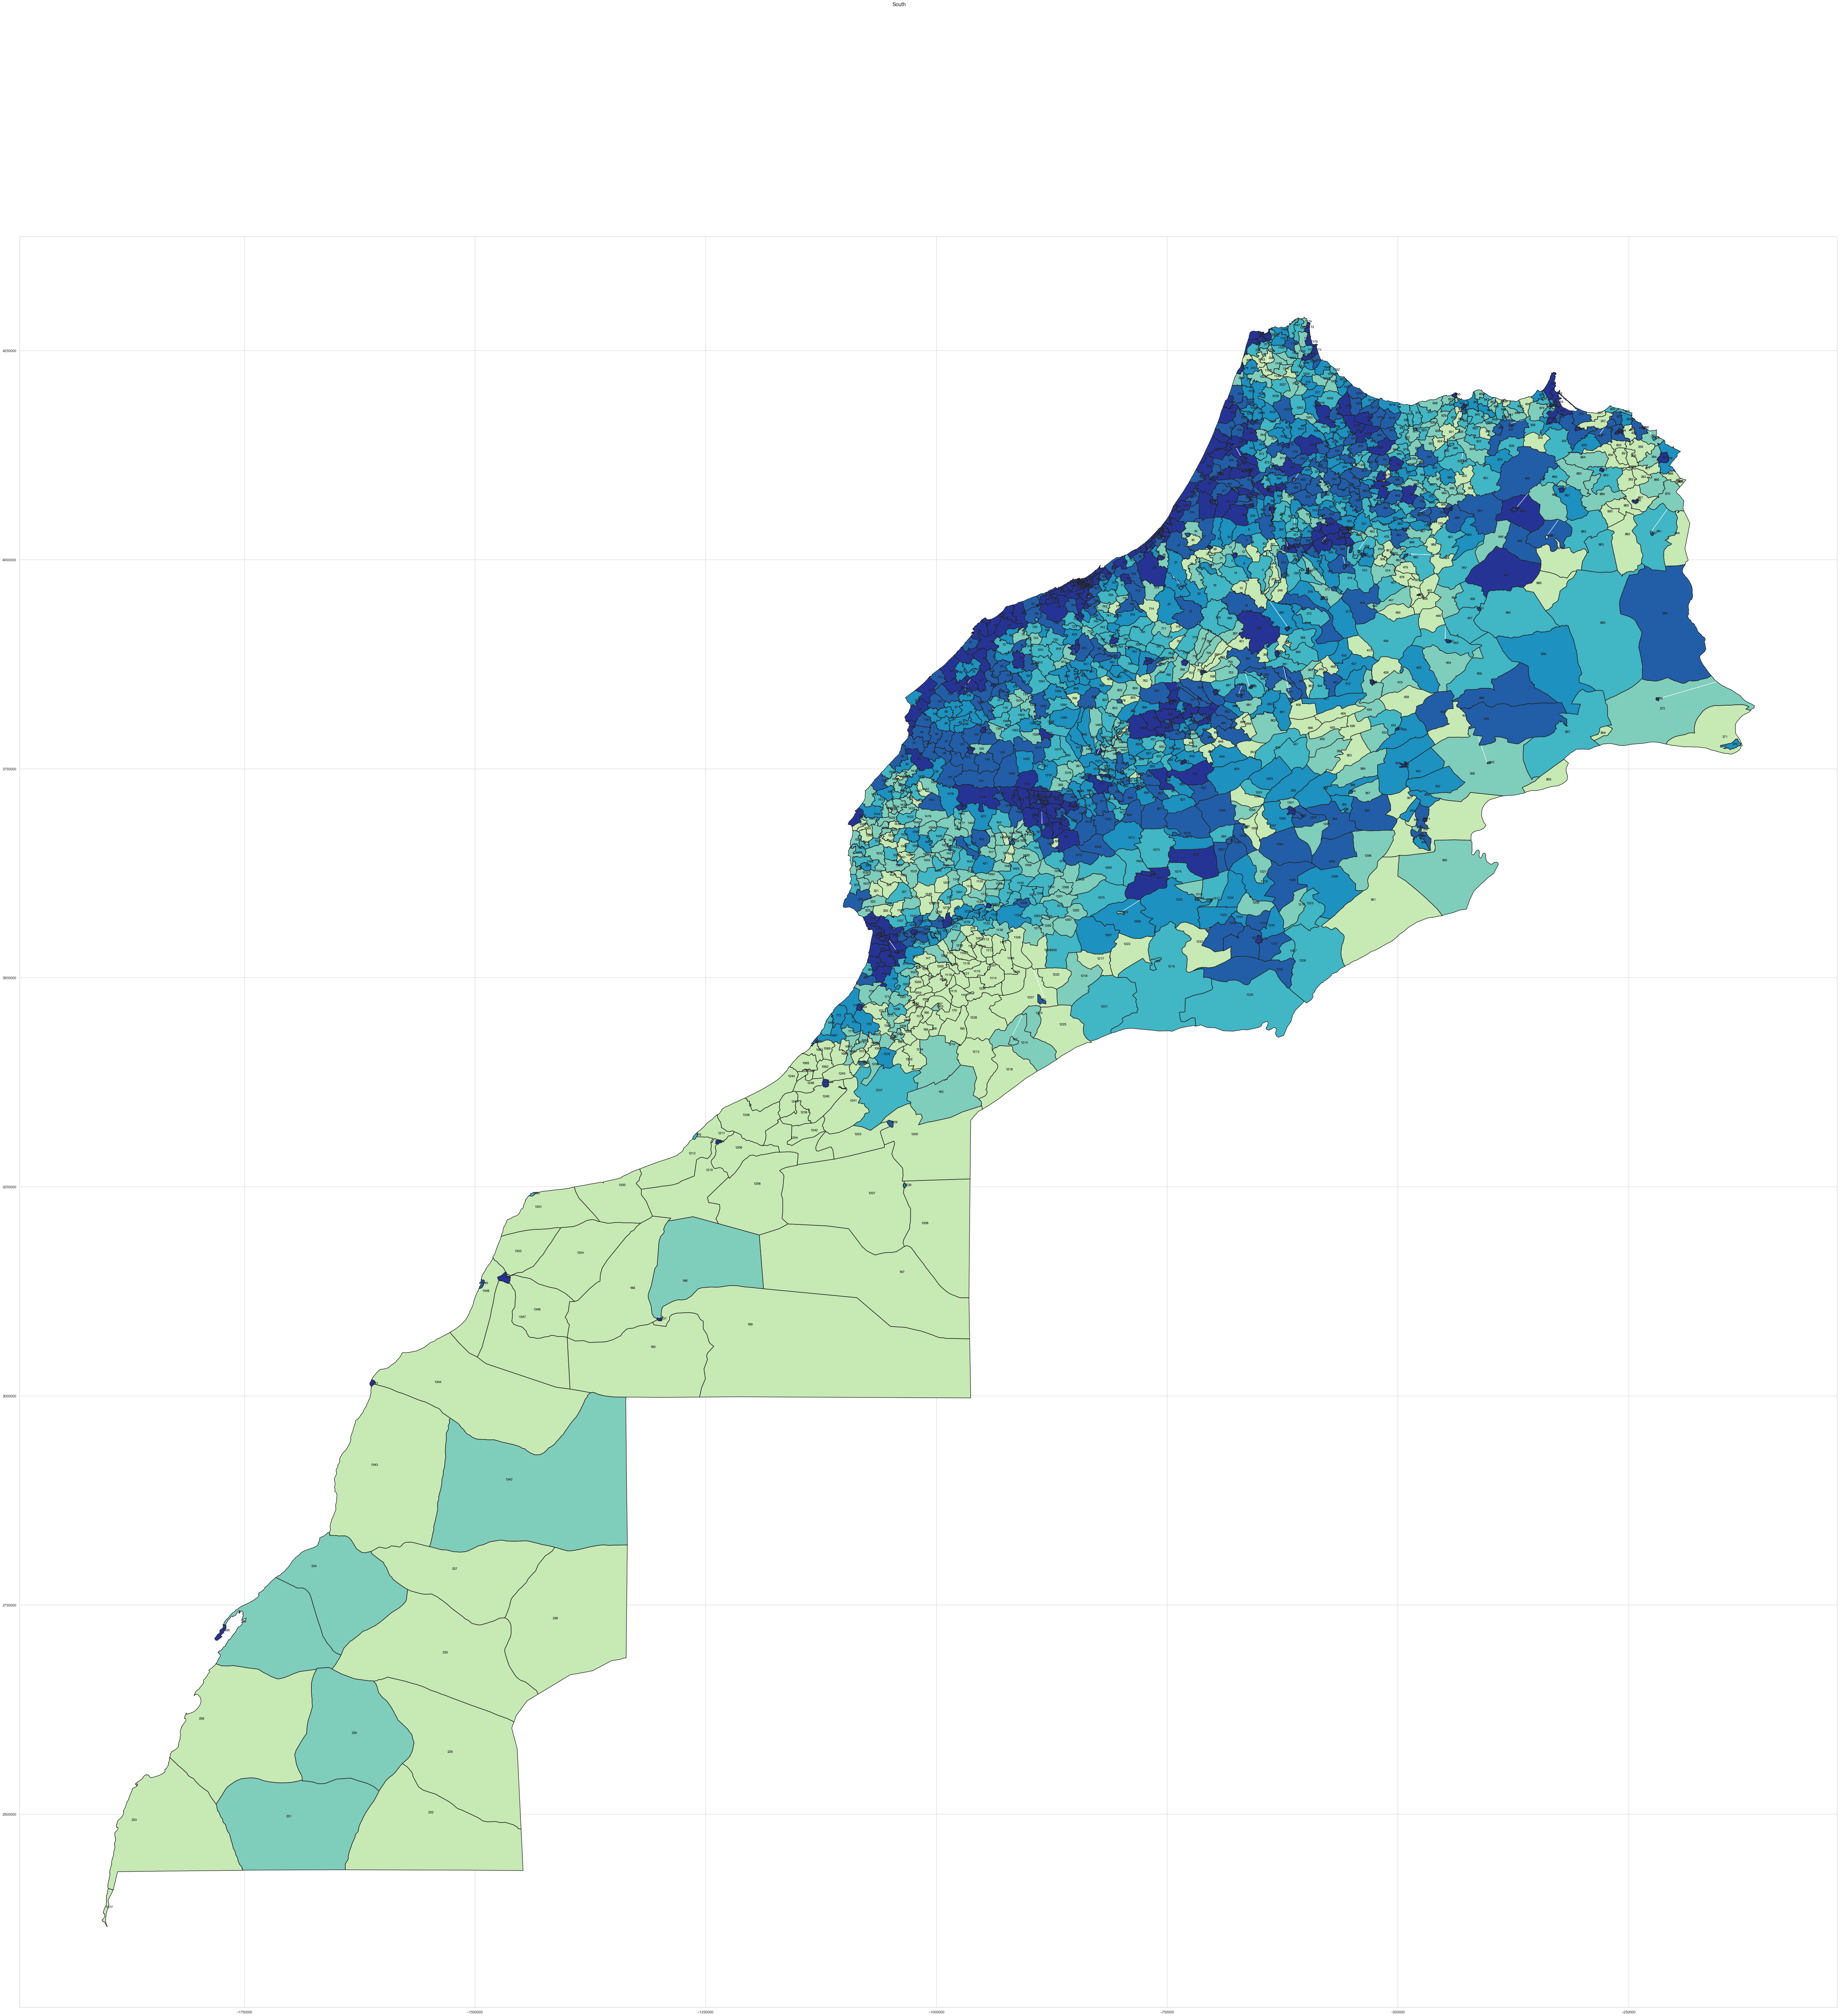

In [57]:
sur = df_data['idCommune']
data = df_data['IPM_c']
print_id = True
plot_comunas_data(sf, 'South', sur, data, 2, print_id)